In [44]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
from convnext import *

# Thư viện PyTorch cho việc xây dựng và huấn luyện mạng nơ-ron
from torch.utils.data import DataLoader  # Cung cấp DataLoader để tải dữ liệu
import torch  # Thư viện cơ bản của PyTorch, chứa các cấu trúc dữ liệu và hàm tính toán trên tensor

# Thư viện torchvision cho xử lý ảnh
from torchvision import transforms  # Các phép biến đổi dữ liệu ảnh
from torchvision.datasets import ImageFolder  # Dataset từ các thư mục chứa ảnh

# Thư viện hỗ trợ tương tác với hệ thống file và thư mục
import os

# Thư viện phổ biến cho tính toán số học trong Python
import numpy as np

# Thư viện vẽ đồ thị và biểu đồ
import matplotlib.pyplot as plt

# Thư viện vẽ confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [46]:
# Kiểm tra xem GPU có sẵn không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
#Đường dẫn tới thư mục chứa dữ liệu
base_dir = '../data'

In [48]:
# Định nghĩa các phép biến đổi dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
# Tạo dataset cho dữ liệu kiểm tra từ thư mục test_data
test_data = ImageFolder(root=os.path.join(base_dir, 'test'), transform=transform)

In [50]:
# Sử dụng hàm Lambda để gán nhãn
test_data.class_to_idx = {'no-watermark': 0, 'watermark': 1}
test_data.targets = [label for _, label in test_data.samples]

In [51]:
batch_size = 50
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [52]:
# Load lại mô hình
#model = convnext_tiny(pretrained=False, in_22k=False, num_classes = 2).to(device)  # Khởi tạo mô hình
if torch.cuda.is_available():
    model = torch.load('improved_watermark_detection_model.pth')
else:
    model = torch.load('improved_watermark_detection_model.pth', map_location=torch.device('cpu'))

#model=torch.load('improved_watermark_detection_model_69.67.pth')

# Chuyển mô hình sang chế độ đánh giá
model.eval()

true_labels = []
predicted_labels = []

correct_predictions = 0
total_predictions = 0

# Duyệt qua từng batch dữ liệu dự đoán và thực hiện dự đoán
with torch.no_grad():
    for batch_data, labels in test_loader:
        # Chuyển dữ liệu và nhãn lên GPU
        batch_data, labels = batch_data.to(device), labels.to(device)

        # Dự đoán nhãn cho từng batch dữ liệu
        outputs = model(batch_data)
        _, predicted = torch.max(outputs, 1)
        
        # Lưu trữ nhãn đúng và nhãn dự đoán vào danh sách
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        # Tính số lượng dự đoán đúng và tổng số lượng dự đoán
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# In ra số lượng dự đoán đúng và tổng số lượng dự đoán
print("Correct predictions:", correct_predictions)
print("Total predictions:", total_predictions)
print("Accuracy:", correct_predictions / total_predictions)

Correct predictions: 93
Total predictions: 122
Accuracy: 0.7622950819672131


In [53]:
def denormalize_image(image_tensor):
    """
    Hàm dùng để giải chuẩn hóa lại ảnh từ tensor đã được chuẩn hóa trước đó.

    Input:
    - image_tensor (torch.Tensor): Tensor của ảnh đã được chuẩn hóa.

    Output:
    - denormalized_image (torch.Tensor): Tensor của ảnh đã được giải chuẩn hóa.
    """
    # Định nghĩa giá trị trung bình và độ lệch chuẩn
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Giải chuẩn hóa ảnh
    denormalized_image = image_tensor.clone()
    for i in range(3):  # Lặp qua từng kênh màu
        denormalized_image[i] = (image_tensor[i] * std[i]) + mean[i]
    
    return denormalized_image


def get_image_and_label_from_loader(test_loader, batch_index, index_in_batch):
    """
    Hàm lấy ảnh và nhãn từ test_loader dựa trên chỉ mục batch và chỉ mục trong batch.

    Tham số:
    - test_loader (torch.utils.data.DataLoader): DataLoader của dữ liệu kiểm tra.
    - batch_index (int): index của batch trong test_loader.
    - index_in_batch (int): index của ảnh trong batch.

    Trả về:
    - image (torch.Tensor): Tensor của ảnh.
    - label (torch.Tensor): Nhãn của ảnh.
    """
    for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
        if batch_idx == batch_index:
            image = batch_data[index_in_batch]
            label = batch_labels[index_in_batch]
            return image, label
    # Trường hợp không tìm thấy batch_index
    return None, None


def visualize(test_loader, true_labels, predicted_labels, choice):
    """
    Hàm trực quan hóa các ví dụ từ test_loader.

    Tham số:
    - test_loader (torch.utils.data.DataLoader): DataLoader của dữ liệu kiểm tra.
    - true_labels (list): Danh sách các nhãn thực tế.
    - predicted_labels (list): Danh sách các nhãn dự đoán.
    - choice (int): Lựa chọn hiển thị, 1 nếu muốn hiển thị các ví dụ dự đoán đúng, 0 nếu muốn hiển thị các ví dụ dự đoán sai.

    Trả về:
    - None
    """
    if choice == 1:
        indices = np.where(np.array(true_labels) == np.array(predicted_labels))[0] 
    elif choice == 0:
        indices = np.where(np.array(true_labels) != np.array(predicted_labels))[0]
    
    num_samples_to_show = min(10, len(indices))
    random_indices = np.random.choice(indices, num_samples_to_show, replace=False)

    plt.figure(figsize=(20, 8))
    for i, index in enumerate(random_indices):
        #Tính index của batch và index của ví dụ trong batch
        batch_index = index // test_loader.batch_size
        index_in_batch = index % test_loader.batch_size
        
        image, true_label = get_image_and_label_from_loader(test_loader, batch_index, index_in_batch)
        predicted_label = predicted_labels[index]

        # Giải chuẩn hóa ảnh
        denormalized_image = denormalize_image(image)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(denormalized_image, (1, 2, 0)))  # Transpose image tensor to (height, width, channels)
        plt.title(f'True label: {true_label}\nPredicted label: {predicted_label}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Some correct prediction images:


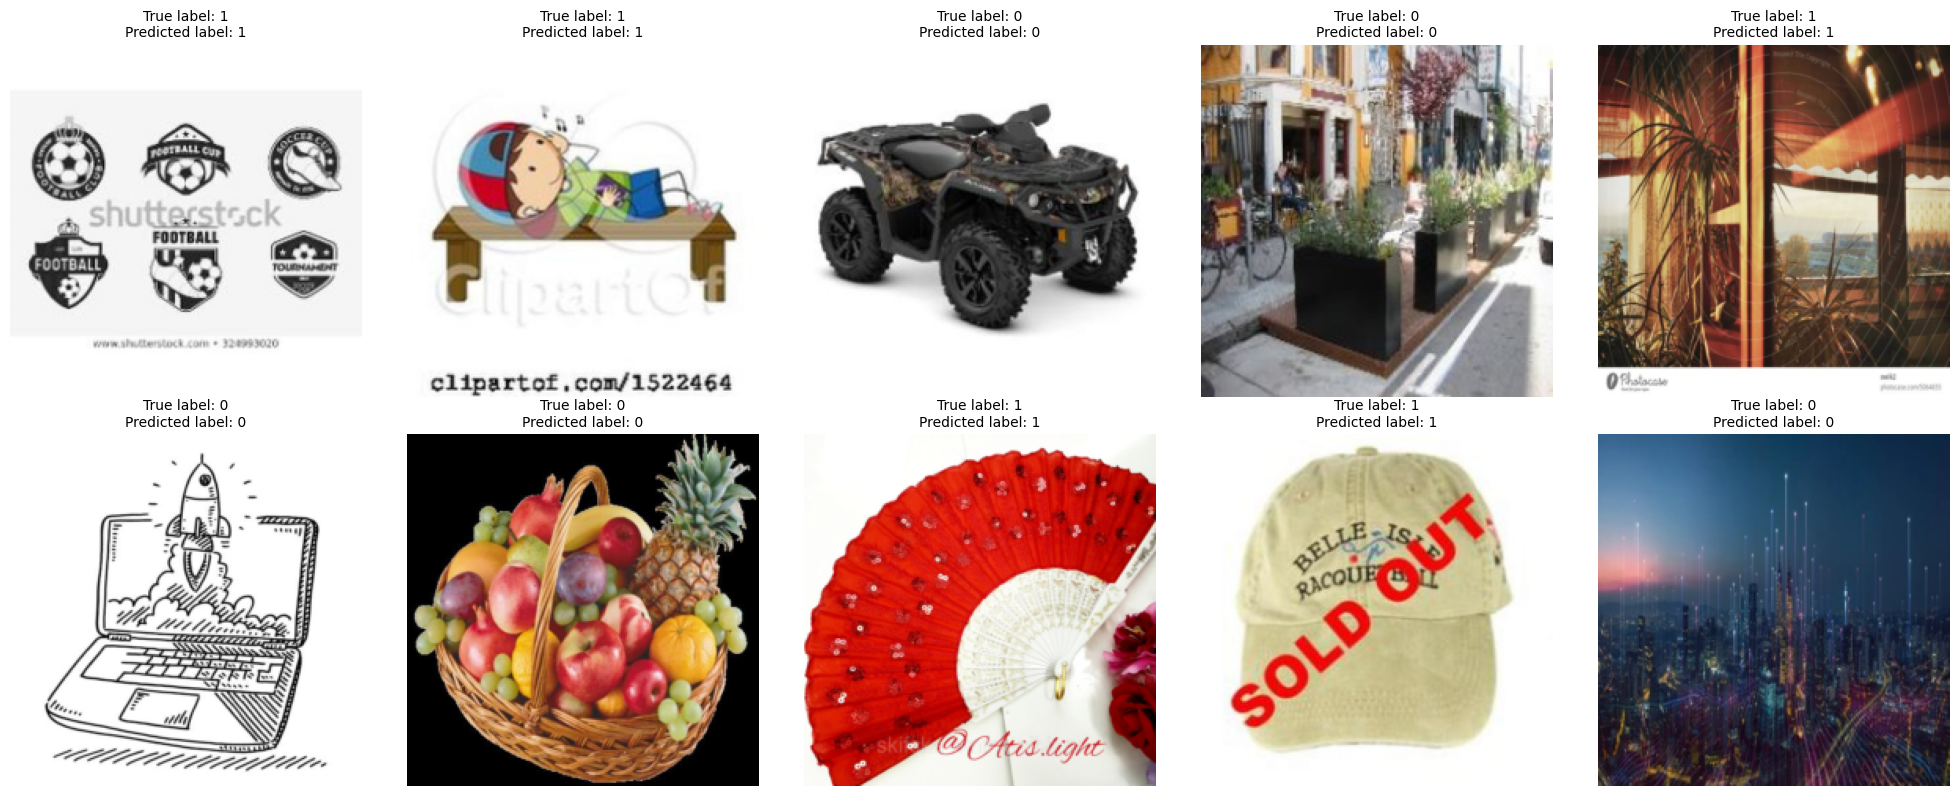

Some incorrect prediction images:


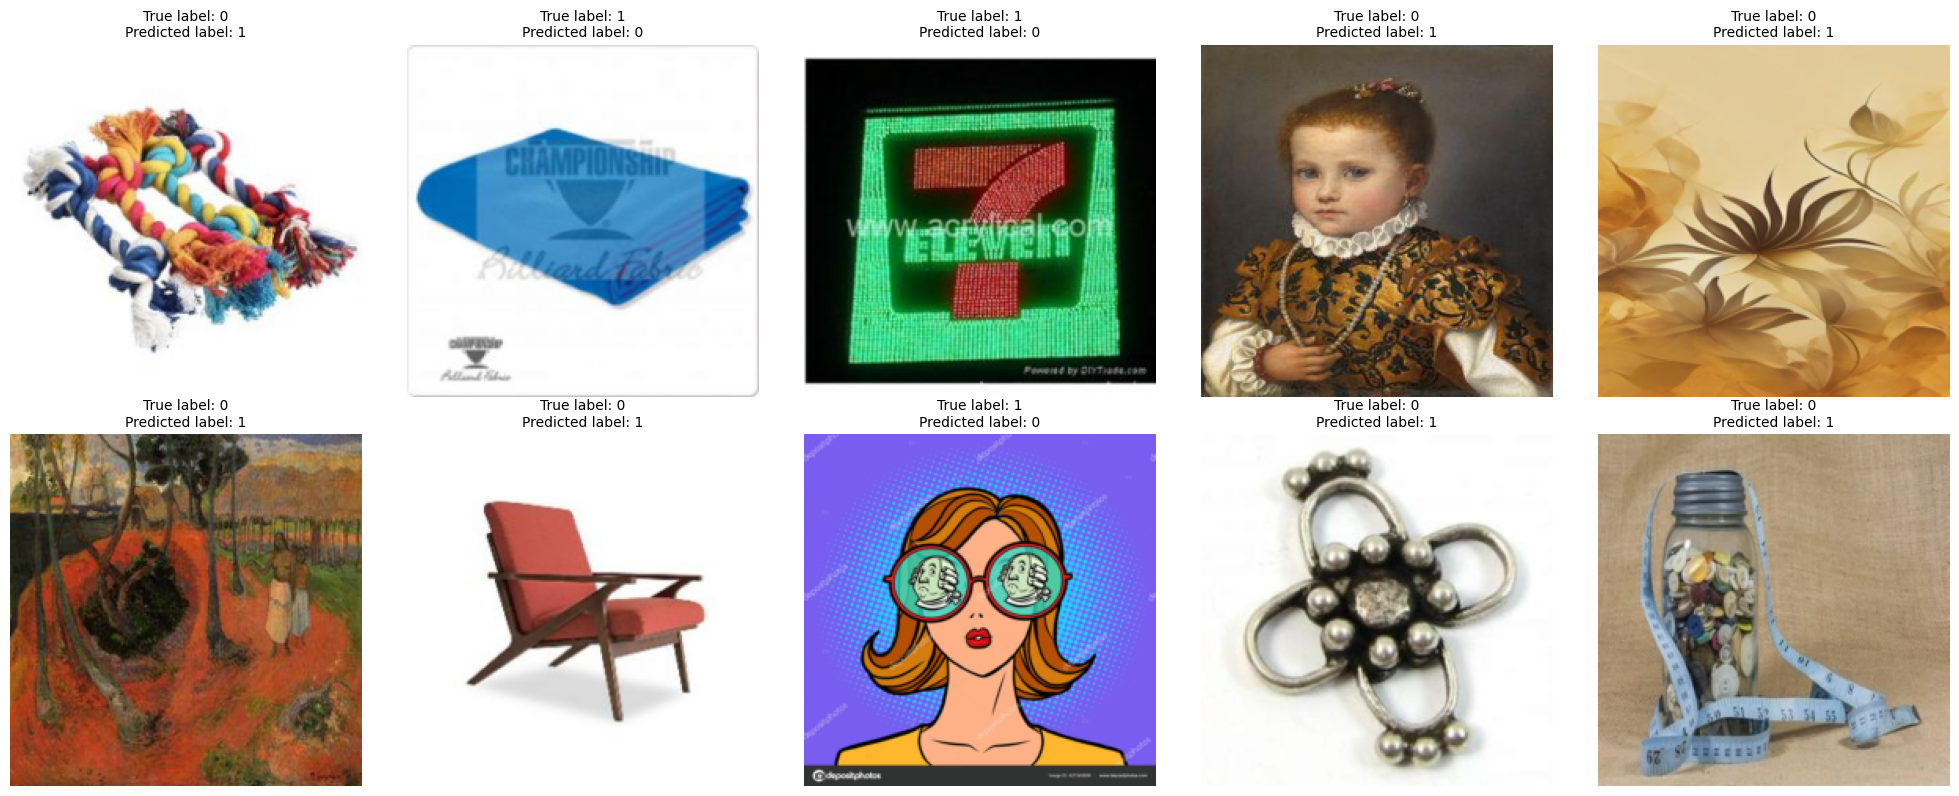

In [54]:
print ("Some correct prediction images:")
visualize(test_loader, true_labels, predicted_labels, 1)

print ("Some incorrect prediction images:")
visualize(test_loader, true_labels, predicted_labels, 0)

In [55]:
def plot_confusion_matrix(true_labels, predicted_labels):
    """
    Hàm vẽ confusion matrix dựa trên list nhãn thực tế và nhãn dự đoán.

    Tham số:
    - true_labels (list): Danh sách các nhãn thực tế.
    - predicted_labels (list): Danh sách các nhãn dự đoán.

    Trả về:
    - None
    """

    # Tính confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Vẽ confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Watermark', 'Watermark'], yticklabels=['No Watermark', 'Watermark'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

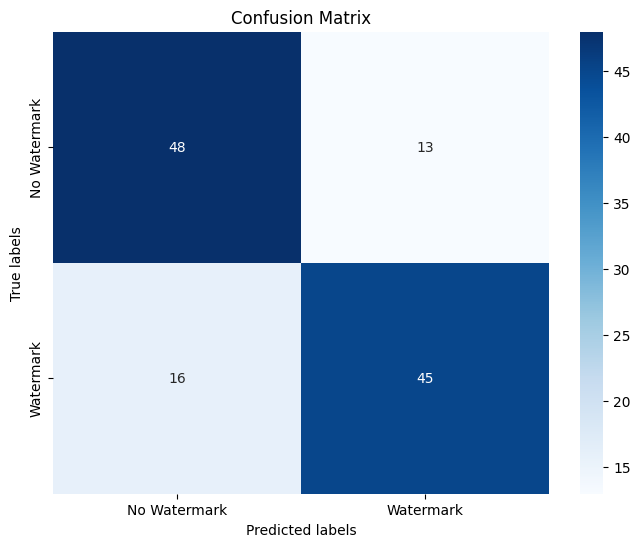

In [56]:
# Sử dụng hàm vẽ confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)